**Machine Learning M1 - 2022**



Auteurs : Benarab Hanane, Kimouche Aïcha, Terroufi Safae, Raihane Hamza


L’objectif de ce projet consistede a proposer des modèles de classification supervisée qui prédit la véracité des claims.

Afin de realiser cette classification, nous avons tout d’abord effectué divers pré-traitements sur les documents. Nous allons ensuite essaye plusieurs classifieurs pour voir lesquels nous semblaient les plus adaptés.


# Mise en place de Google Drive et de fonctions

Le bout de code ci-dessous est optionnelle et permet de se connecter à notre google drive afin d'accéder aux données à traiter.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Initialisation de fonctions globales qui serviront tout le long de notre étude.

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

def display_barplot(df, title, x, xlabel, y, ylabel, orient):
  
  # --- Colors
  colors = sn.color_palette('Reds_d', n_colors=len(df))

  # --- Barplot
  plt.figure(figsize=(15,5))
  g = sn.barplot(x=x, y=y,
             palette = colors,
             data=df, 
             orient=orient)

  # --- Annotations
  for p in g.patches:
    if orient == 'v':
      g.annotate('{:.2f}'.format(
          p.get_height()), 
          (p.get_x()+0.4, p.get_height()),
          ha='center', va='bottom',
          color= 'black')
    else:
      g.annotate('{:.2f}'.format(
          p.get_width()), 
          (p.get_width()+0.02, p.get_y()+0.4),
          ha='left', va='center',
          color='black')
    
  # --- Cosmetic
  plt.title(title, size=18)
  plt.xlabel(xlabel, size=15)
  plt.ylabel(ylabel, size=15)
  sn.despine()

def to_percent(n):
 
  return n*100

# 1 - Extraction des données 



In [ ]:
import pandas as pandas
import glob, os , io
from google.colab import files 

uploaded = files.upload()
# Méthode locale
# df = pandas.concat( map( pandas.read_csv, glob.glob(os.path.join('', "./datasets/*.csv"))))

# Méthode drive
df = pandas.read_csv(io.BytesIO(uploaded['claimskg_result.csv'])) 
print(df)

Saving claimskg_result.csv to claimskg_result.csv
                                                     id  \
0     http://data.gesis.org/claimskg/claim_review/c2...   
1     http://data.gesis.org/claimskg/claim_review/1e...   
2     http://data.gesis.org/claimskg/claim_review/0b...   
3     http://data.gesis.org/claimskg/claim_review/a1...   
4     http://data.gesis.org/claimskg/claim_review/b4...   
...                                                 ...   
9995  http://data.gesis.org/claimskg/claim_review/e3...   
9996  http://data.gesis.org/claimskg/claim_review/ad...   
9997  http://data.gesis.org/claimskg/claim_review/05...   
9998  http://data.gesis.org/claimskg/claim_review/98...   
9999  http://data.gesis.org/claimskg/claim_review/eb...   

                                                   text        date  \
0     'And the revenue generated by drilling off Vir...  2012-02-15   
1     Health insurance companies pay CEOs $24 millio...  2009-09-15   
2     Ted Cruz said that vet

Analysons les données nulles présentes dans notre dataframe

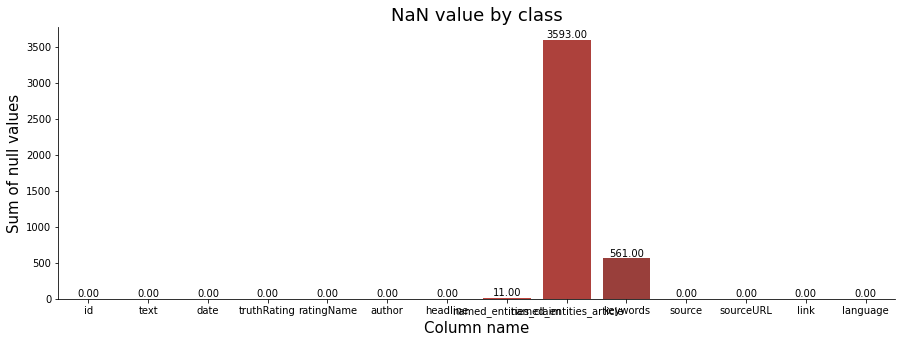

In [ ]:
null_sums = [df[column].isnull().sum() for column in df.columns]

sums_df = pandas.DataFrame({
    'Columns': df.columns, 
    'Null_sums': null_sums})

display_barplot(sums_df, 'NaN value by class', 
                'Columns', 'Column name', 
                'Null_sums', 'Sum of null values',
                'v')

La donnée principal, *text*, ne comporte aucune cellule nulle, ce qui veut dire que nous pouvons remplacer les autres cellules nulles en une chaîne de caractères vide. Nous pouvons nous le permettre car ce sont des données additionnels que nous ajouterons plus tard. 

Ceci permettra d'éviter la perte de plus d'1/3 de nos données, de part les 9112 lignes qui auraient étaient supprimées en utilisant une méthode *dropna* traditionnelle, et de conserver un maximum d'information.

In [ ]:
for column in df.columns:
  df[column].fillna(value='', inplace=True)
  
nb_row = df.shape[0]

df.head()


,id,text,date,truthRating,ratingName,author,headline,named_entities_claim,named_entities_article,keywords,source,sourceURL,link,language
0,http://data.gesis.org/claimskg/claim_review/c2...,'And the revenue generated by drilling off Vir...,2012-02-15,2,MIXTURE,Jim Moran,Moran says drilling off Virginia's coast will ...,"Alaska,American Petroleum Institute,Atlantic O...",,"Energy,State Finances",politifact,http://www.politifact.com,http://www.politifact.com/virginia/statements/...,English
1,http://data.gesis.org/claimskg/claim_review/1e...,Health insurance companies pay CEOs $24 millio...,2009-09-15,2,MIXTURE,Health Care for America Now,Health care advocacy group blasts insurers for...,"Aetna,Assurant,Bloomberg News,Cigna,Coventry H...",,"Corporations,Health Care",politifact,http://www.politifact.com,http://www.politifact.com/truth-o-meter/statem...,English
2,http://data.gesis.org/claimskg/claim_review/0b...,Ted Cruz said that veterans should start selli...,Unknown,1,FALSE,Unknown,Ted Cruz: Vets Should Sell Cookies for Funding...,"David Nelson,James Morrison,John Scalzi,Republ...",Ted Cruz,"ASP Article, Not Necessarily The News",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/cruz-cookies/,English
3,http://data.gesis.org/claimskg/claim_review/a1...,Passengers on an airliner diverted to Cuba tho...,Unknown,2,MIXTURE,Unknown,Did Airline Passengers Mistake a Hijacking for...,"Allen Funt,Associated Press,CBS,Candid Camera,...","Allen Funt,Candid Camera,Cuba","Broadcast Legends, Radio & TV, Television",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/candid-camer...,English
4,http://data.gesis.org/claimskg/claim_review/b4...,Oil money from federal leases 'can only be use...,2009-06-15,2,MIXTURE,Bill Nelson,Sen. Bill Nelson says offshore drilling won't ...,"Alabama,Bill Nelson,D-Fla,Florida Panhandle,Gu...",,Environment,politifact,http://www.politifact.com,http://www.politifact.com/truth-o-meter/statem...,English


# 2 - Prétraitement des données.

Le prétraitement des données consiste à modifier les valeurs des colonnes numériques du jeu de données pour utiliser une échelle commune, sans que les différences de plages de valeurs ne soient faussées et sans perte d'informations.

Nous avons choisis :

- Le Stemming -> Réduit les mots en leur radical ou un dérivé.

- La supression de caractères non ASCII -> Normalisation du texte en supprimant tous les caractères non ASCII.

- Passage en minuscule ->Normalisation du texte en supprimant tous les caractères non ASCII. Ce qui va env rien changer le sens du claim, il perdra juste en poids.


- Supression de la ponctuation -> le but des pre-traitements est de réduire le nombre de mots différents afin d’avoir une vitesse d’execution raisonnable. Nous avons estimé que les signes de ponctuation pouvaient être
ambivalents et qu’il n’etait pas forcément judicieux de les garder.

- Suppressions des stopwords ->, il existe un grand nombre de mots qui servent de lien a une grammaire syntaxique mais qui n’ont pas de signification propre (et donc pas de polarité). 
Nous les avons donc supprimes afin de gagner un grand temps de calcul sans perdre de précision sur le classifieur.



In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Suppression des chiffres

De même que la ponctuation, les nombres sont peu informatifs et peuvent être supprimée. Nous aurions aussi pû les remplacer par du texte mais cela ajouterai des données supplémentaires "inutiles" à traiter pendant l'apprentissage.

In [ ]:
import inflect

mock_text = " est ce que ca marche si je met 32974  "
words = word_tokenize(mock_text)

def remove_numbers(text):
 
  return ''.join(filter(lambda x: not x.isdigit(), text))

result = remove_numbers(mock_text)
print(result)


 est ce que ca marche si je met   


## Stemming

In [ ]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')


def stem_words(text):
  
  tokens = word_tokenize(text)
  return ' '.join([ stemmer.stem(word) for word in tokens ])



## Gestion du texte non ascii

On normalise notre texte en supprimant tout les caractères non ascii. Certains langage nécessiterais ces caractères mais ici nous ne traitons que des documents en anglais donc ce n'est pas nécessaire.

In [ ]:
import unicodedata

mock_text = " Ëst cê quë cà mârchê "
words = word_tokenize(mock_text)

def remove_non_ascii(words):
 
  new_words = []
  for word in words:
    new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf8')
    
    if new_word:
      new_words.append(new_word)
      
  return new_words

print(' '.join(remove_non_ascii(words)))

Est ce que ca marche


## Conventir majuscule au miniscule

C'est la technique de prétraitement de texte la plus courante et la plus simple. Elle permet de convertir le texte en minuscule afin de réduire considérablement les tests à établir.

In [ ]:
# exemple
mock_text = " EST CE QUE CA MARCHE "
words = word_tokenize(mock_text)

def to_lowercase(words):
  
  return [word.lower() for word in words]

print(' '.join(to_lowercase(words)))

est ce que ca marche


## Supprission des mots de taille 1

On supprime les mots de taille 1 car ils apportent peu voire aucunes informations, les supprimer favoriseras donc la rapidité de notre apprentissage.

In [ ]:
mock_text = " Just a a a simple text to a a a test"
words = word_tokenize(mock_text)

def remove_single_char(words):

  return [word for word in words if len(word) > 1]

print(' '.join(remove_single_char(words)))

Just simple text to test


## Supprission de la Punctuations

La ponctuation importe peu, elle est donc inutile à analyser, il convient donc de la retirer de notre jeu de donnés.


In [ ]:
import re

mock_text = " Est ! ce ! que???? ça ... marche***** "
words = word_tokenize(mock_text)

def remove_punctuation(words):
  """
  Remove punctuation in the list of words
  @param words: (list) Tokenize list of words
  @return words: (list) The same list of words except punctuation
  """
  return [re.sub('[^\w\s]','', word) for word in words if re.sub('[^\w\s]','', word)]

print(' '.join(remove_punctuation(words)))

Est ce que ça marche


## Suppression des chiffres

De même que la ponctuation, les nombres sont peu informatifs et peuvent être supprimée. Nous aurions aussi pû les remplacer par du texte mais cela ajouterai des données supplémentaires "inutiles" à traiter pendant l'apprentissage.

In [ ]:
import inflect

mock_text = " ces chiffres 537394 et 742048 sont inutiles"
words = word_tokenize(mock_text)

def remove_numbers(text):

  return ''.join(filter(lambda x: not x.isdigit(), text))

result = remove_numbers(mock_text)
print(result)

# --- On pourrait les remplacer si nécessaire avec cette fonction
# def replace_numbers(words):
#   p = inflect.engine()
#   return [p.number_to_words(word) if word.isdigit() else word for word in words]

# result = replace_numbers(words)
# print(''.join(result))

 ces chiffres  et  sont inutiles


## Supprission des Stop-word 

Un mot d'arrêt est un mot couramment utilisé (tel que "the", "a", "an", "in) Ils révèlent peu voire pas d'informations, on peut donc les enlever.

NLTK fournis une liste comlète de mots d'arrêts en anglais, nous nous en serviront donc pour faire le tris.

In [ ]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

mock_text = "It's in english because a stopwords as to be in english"
words = word_tokenize(mock_text)

def remove_stopwords(words):

  return [word for word in words if word not in stopwords]

print(' '.join(remove_stopwords(words)))

It 's english stopwords english


## Nettoyage du text

Nous sommes maintenant en mesure de nettoyer notre texte efficacement de la manière suivante

In [ ]:
mock_text = "This têxt îs 100000 better ******* "

def normalize(words):
 
  words = remove_non_ascii(words)
  words = to_lowercase(words)
  words = remove_punctuation(words)
  words = remove_single_char(words)
  words = remove_stopwords(words)
  return words

def clean_text(text):
  
  text = remove_numbers(text)
  words = word_tokenize(text)
  words = normalize(words)
  return ' '.join(words)

def clean_dataframe_text(column_name):
 
  df[column_name] = df[column_name].apply(lambda x: clean_text(x))

clean_text(mock_text)

'text better'

Appliquons notre fonction sur les différentes données de notre dataframe.

In [ ]:
df["text"] = df["text"].apply(stem_words)
clean_dataframe_text("text")

df["headline"] = df["headline"].apply(stem_words)
clean_dataframe_text("headline")

clean_dataframe_text("keywords")
clean_dataframe_text("author")
clean_dataframe_text("named_entities_claim")
clean_dataframe_text("named_entities_article")

Redéfinissons notre dataframe en utilisant nos données nettoyées.

In [ ]:
data = [ df["text"],
        df["date"],
        df["author"],
        df["headline"],
        df["named_entities_claim"],
        df["named_entities_article"],
        df["keywords"],
        df["source"],
        df["sourceURL"],
        df["link"],
        df["language"],
        df["truthRating"],
        df["ratingName"]]

headers = ["text", "date", "author", "headline", "named_entities_claim", 
           "named_entities_article", "keywords", "source", "sourceURL", 
           "link", "language", "truthRating", "ratingName"]

df = pandas.concat(data, axis=1, keys=headers)
df.head()

,text,date,author,headline,named_entities_claim,named_entities_article,keywords,source,sourceURL,link,language,truthRating,ratingName
0,revenu generat drill virginia coast million year,2012-02-15,jim moran,moran say drill virginia coast net onli millio...,alaska american petroleum institute atlantic o...,,energy state finances,politifact,http://www.politifact.com,http://www.politifact.com/virginia/statements/...,English,2,MIXTURE
1,health insur compani pay ceo million year,2009-09-15,health care america,health care advocaci group blast insur ceo pay...,aetna assurant bloomberg news cigna coventry h...,,corporations health care,politifact,http://www.politifact.com,http://www.politifact.com/truth-o-meter/statem...,English,2,MIXTURE
2,ted cruz said veteran start sell cooki order r...,Unknown,unknown,ted cruz vet sell cooki fund like girl scout,david nelson james morrison john scalzi republ...,ted cruz,asp article necessarily news,snopes,http://www.snopes.com,https://www.snopes.com/fact-check/cruz-cookies/,English,1,FALSE
3,passeng airlin divert cuba thought hijack cand...,Unknown,unknown,airlin passeng mistak hijack candid camera stunt,allen funt associated press cbs candid camera ...,allen funt candid camera cuba,broadcast legends radio tv television,snopes,http://www.snopes.com,https://www.snopes.com/fact-check/candid-camer...,English,2,MIXTURE
4,oil money feder leas onli use clean mess damag...,2009-06-15,bill nelson,sen bill nelson say offshor drill wo nt pay fl...,alabama bill nelson dfla florida panhandle gul...,,environment,politifact,http://www.politifact.com,http://www.politifact.com/truth-o-meter/statem...,English,2,MIXTURE


# 3 - Classification 


Maintenant que l'on a prétraité les données de notre dataframe nous pouvons commencer à utiliser des modèles. Les différents classifieur de Scikit-learn ne sont pas compatible avec du texte. Il faut donc re-processer les données déjà nettoyées.
Nous avons applique cette méthode sur les classifieurs suivants : LogisticRegression, KNeighbors, DecisionTree, GaussianNB et RandomForest.

Le choix de ces classifieurs a eté justifié par plusieurs raisons. En effet, une grande partie de ces classifieurs ont eté étudiés en cours, il était donc plus simple de les appréhender et d’améliorer leur performances. Ensuite, nous nous sommes beaucoup renseigne sur le site scikit-learn qui propose à la fois une explication pour le fonctionnement des classifieurs, mais aussi une explication pour leurs parametres. 

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Définir la variable dépendante et indépendante comme x et y

#x = df['claimReview_Verdict']
#y = df["rating_alternateName"]
#id	text	date	truthRating	ratingName	author	headline	named_entities_claim	named_entities_article	keywords	source	sourceURL	link	language
x = df['text']

y = df['ratingName']

# Séparer le dataset au dessus en données d'entrainement et de test 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
count_vectorizer = CountVectorizer(stop_words='english')

print('Train set:', x_train.shape)
print('Test set:', x_test.shape)



Train set: (7000,)
Test set: (3000,)


In [ ]:
#convertire le texte en vecteur
from sklearn.feature_extraction.text import TfidfVectorizer
# Manipulation de données vectoriel
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

print(xv_train.shape)
print(xv_test.shape)

(7000, 9402)
(3000, 9402)


# **N gramms**
---
Après avoir nettoyer nos données, on propose maintenant de separer le text en "sac de mot". Après cela, nous pouvons commencé à utiliser les classifieurs.



In [ ]:
# Generate n-grams upto n=1


vectorizer_ng1 = CountVectorizer(ngram_range=(1, 1))
ng1 = vectorizer_ng1.fit_transform(x)
print("nn-grammes de tailles 1")
print(vectorizer_ng1.get_feature_names())



# Generate n-grams upto n=2
vectorizer_ng2 = CountVectorizer(ngram_range=(1, 2))
ng2 = vectorizer_ng2.fit_transform(x)
print("nn-grammes de tailles 1 et 2")
print(vectorizer_ng2.get_feature_names())

# Generate n-grams upto n=3
vectorizer_ng3 = CountVectorizer(ngram_range=(2, 3))
ng3 = vectorizer_ng3.fit_transform(x)
print("nn-grammes de tailles 2 et 3")
print(vectorizer_ng3.get_feature_names())

vectorizer_ng3 = CountVectorizer(ngram_range=(3, 3))
ng3 = vectorizer_ng3.fit_transform(x)
print("nn-grammes de tailles 3")
print(vectorizer_ng3.get_feature_names())
# Print the number of features for each model
#taille des modeles

print("nn-grammes de caractères de tailles 1 et 2 ")
vectorizer=CountVectorizer(analyzer='char',ngram_range=(1,2))
X=vectorizer.fit_transform(x)


nn-grammes de tailles 1
['12', 'aa', 'aaa', 'aaron', 'aarp', 'ab', 'aba', 'abaco', 'abandon', 'abbey', 'abbi', 'abbott', 'abbrevi', 'abc', 'abdallah', 'abdomen', 'abduct', 'abdul', 'abdullah', 'abe', 'abedi', 'abedin', 'abel', 'abercrombi', 'abid', 'abigail', 'abil', 'abject', 'abl', 'abnorm', 'aboard', 'abolish', 'abolit', 'abort', 'abortionist', 'abov', 'abraham', 'abram', 'abramovich', 'abroad', 'abrupt', 'absenc', 'absent', 'absente', 'absolut', 'absorb', 'abstin', 'abus', 'aca', 'academ', 'academi', 'accept', 'access', 'accid', 'accident', 'accommod', 'accomplic', 'accomplish', 'accord', 'accordion', 'account', 'accredit', 'accru', 'accrual', 'accumul', 'accur', 'accuraci', 'accus', 'acela', 'acesha', 'acetylsalicyl', 'achiev', 'acid', 'acknowledg', 'aclu', 'acn', 'acorn', 'acosta', 'acquaint', 'acquir', 'acquit', 'acr', 'acronym', 'across', 'acrost', 'act', 'action', 'actionedit', 'activ', 'activist', 'actor', 'actress', 'actual', 'acupunctur', 'acut', 'ad', 'adag', 'adam', 'adan

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


nn-grammes de tailles 1 et 2
['12', '12 time', 'aa', 'aa batteri', 'aaa', 'aaa bond', 'aaron', 'aaron bean', 'aaron buerg', 'aaron hernandez', 'aarp', 'aarp inconsist', 'aarp largest', 'ab', 'ab violent', 'aba', 'aba symbol', 'abaco', 'abaco island', 'abandon', 'abandon anim', 'abandon experiment', 'abandon groundbreak', 'abandon militari', 'abandon practic', 'abandon republican', 'abandon social', 'abandon someth', 'abbey', 'abbey juli', 'abbi', 'abbott', 'abbott becom', 'abbott campaign', 'abbott charg', 'abbott gift', 'abbott head', 'abbott lost', 'abbott noth', 'abbrevi', 'abbrevi lol', 'abc', 'abc bleep', 'abc cbs', 'abc fire', 'abc news', 'abc nt', 'abc privat', 'abdallah', 'abdallah ahm', 'abdomen', 'abduct', 'abduct attempt', 'abduct child', 'abduct rape', 'abduct sex', 'abduct took', 'abduct tot', 'abdul', 'abdul elsay', 'abdullah', 'abdullah ii', 'abe', 'abe lincoln', 'abedi', 'abedi father', 'abedin', 'abedin seen', 'abedin work', 'abel', 'abel elimin', 'abel five', 'abel on

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection, svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
import numpy as np

ng_vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train_ng = ng_vectorizer.fit_transform(x_train)
X_test_ng = ng_vectorizer.transform(x_test)
# tout les noms des classifieurs :
t_NB = MultinomialNB()
DT =DecisionTreeClassifier()
LR = LogisticRegression()
SVM = svm.SVC(C=1.9, kernel='linear')

DT.fit(X_train_ng, y_train)
t_NB.fit(X_train_ng, y_train)
LR.fit(X_train_ng, y_train)
SVM.fit(X_train_ng, y_train)

# Prediction du claim pour un avis negatif ou positif
DT.predict(X_test_ng)
t_NB.predict(X_test_ng)
LR.predict(X_test_ng)
SVM.predict(X_test_ng)

# prediction 

accuracy1 = DT.score(X_test_ng, y_test)

accuracy2 = t_NB.score(X_test_ng, y_test)

accuracy3 = LR.score(X_test_ng, y_test)

accuracy4=SVM.score(X_test_ng,y_test)




In [ ]:
print("l'accuracy du modele de l'arbre de decision en utilisant les parametre par defaut est de :  ", accuracy1)

N, train_score, val_score = learning_curve(DT, X_train_ng, y_train,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=2)

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('LR = train_sizes')
plt.legend()


l'accuracy du modele de l'arbre de decision en utilisant les parametre par defaut est de :   0.47633333333333333


In [ ]:
print("l'accuracy du modele de l'arbre de Naive Bayes en utilisant les parametre par defaut est de :  ", accuracy2)
N, train_score, val_score = learning_curve(t_NB, X_train_ng, y_train,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=2)

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('LR = train_sizes')
plt.legend()

l'accuracy du modele de SVM en utilisant les parametre par defaut est de :   0.5403333333333333


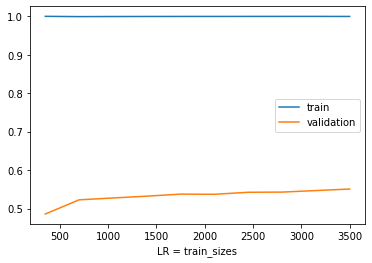

In [ ]:
print("l'accuracy du modele de SVM en utilisant les parametre par defaut est de :  " , accuracy4)
N, train_score, val_score = learning_curve(SVM, X_train_ng, y_train,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=2)

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('LR = train_sizes')
plt.legend()

l'accuracy du modele de l'arbre de Logistic Regression en utilisant les parametre par defaut est de :   0.56


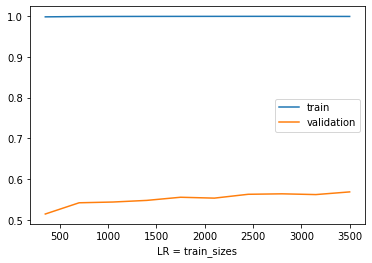

In [ ]:
print("l'accuracy du modele de l'arbre de Logistic Regression en utilisant les parametre par defaut est de :  " , accuracy3)
N, train_score, val_score = learning_curve(LR, X_train_ng, y_train,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=2)

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('LR = train_sizes')
plt.legend()

### Initialisation des fonctions

In [ ]:
def display_confusion_matrix(confusion_matrix, labels=[]):
  
  sn.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
  plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

TFIDF_VECT = TfidfVectorizer()

def get_pipeline(classifier):
  
  return Pipeline([('tfidf', TFIDF_VECT),
                   ('clf', classifier)])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix
from time import time

SEED = 42

def apply_classifier(pipeline, data, target, disp=False, classifier_name=''):
  
  # --- Mise en place du jeu de test
  validation_size = 0.4
  testsize= 1 - validation_size
  X_train, X_test, y_train, y_test = train_test_split(
      data, 
      target, 
      train_size=validation_size, 
      test_size=testsize,
      random_state=SEED,
      stratify=target
  )

  if disp: print("# --- Application du classifieur", classifier_name)

  # --- Fit
  t0 = time()
  pipeline.fit(X_train, y_train)
  if disp: print("[~] Fit réalisé en %0.3fs" % (time() - t0))

  # --- Predict
  t0 = time()
  result = pipeline.predict(X_test)
  if disp: print("[~] Prédiction réalisée en %0.3fs\n" % (time() - t0))

  # --- Accuracy & confusion matrix
  accuracy = pipeline.score(X_test, y_test)
  conf = confusion_matrix(y_test, result)

  if disp:
    print('[+] Accuracy: %0.3f%%' % to_percent(accuracy))
    print('\n[~] Matrice de confusion:')
    labels = np.unique(y_test)
    display_confusion_matrix(conf, labels)
    print('\n[~] Rapport de classification: \n', classification_report(y_test, result))

  return accuracy


prenons exemple du classifiers LogisticRegression. 



# --- Application du classifieur 
[~] Fit réalisé en 1.423s
[~] Prédiction réalisée en 0.084s

[+] Accuracy: 57.400%

[~] Matrice de confusion:


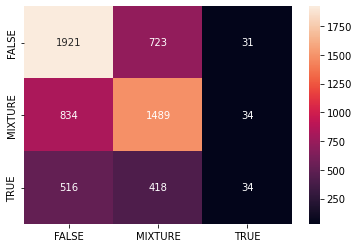


[~] Rapport de classification: 
               precision    recall  f1-score   support

       FALSE       0.59      0.72      0.65      2675
     MIXTURE       0.57      0.63      0.60      2357
        TRUE       0.34      0.04      0.06       968

    accuracy                           0.57      6000
   macro avg       0.50      0.46      0.44      6000
weighted avg       0.54      0.57      0.53      6000



In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(n_jobs=-1)
pipeline = get_pipeline(classifier)

data = df['text']
target = df['ratingName'].astype('string')

result = apply_classifier(pipeline, data, target, True)

## Equilibrage dans le dataset

L'équilibrage des donnée permet de s'assurer que notre classifieur ne soit pas biaisé dans ses choix de réponse. Après son apprentissage, le classifieur tendras facilement à dire qu'une assertion est fausse car il n'auras pas assez d'informations pour discerner correctement celles qui sont vraies. C'est ce qu'on appelle des **faux négatif**. Voilà pourquoi l'équilibrage est très important.


In [ ]:
def display_pie(dataframe, column_name, title=''):
  
  dataframe[column_name].value_counts().plot(
      kind='pie', 
      figsize=(6,10),
      title=title, 
      fontsize=11, 
      legend=True,
      shadow=True,
      autopct='%1.1f%%'
  )
  plt.show()

### Répartition général

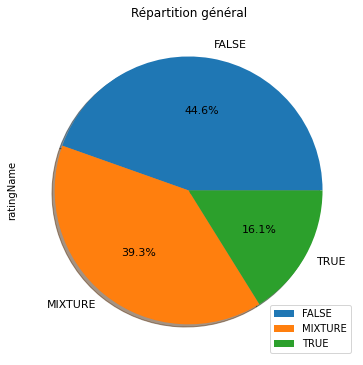

Statistique:
FALSE      4458
MIXTURE    3928
TRUE       1614
Name: ratingName, dtype: int64


In [ ]:
display_pie(df, 'ratingName', 'Répartition général')

print("Statistique:")
print(df["ratingName"].value_counts())


Dans le cadre du projet nous devrons nous intéresser aux tâches suivantes:

**1. True vs False**

**2. (True || False) vs Mixture**

**3. True vs False vs Mixture**



### Répartition True vs False

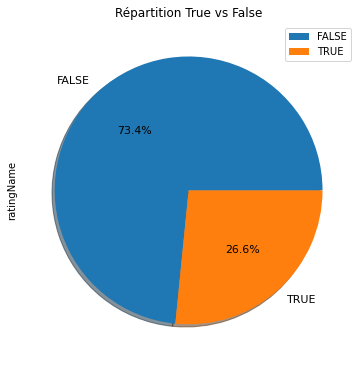

Statistique:
FALSE    4458
TRUE     1614
Name: ratingName, dtype: int64 




In [ ]:
df_TF = df[df.truthRating != 2]
display_pie(df_TF, 'ratingName', 'Répartition True vs False')

print("Statistique:")
print(df_TF["ratingName"].value_counts(), '\n\n')

### Répartition False et Mixture

Les méthodes de rééquilibrage peuvent provoquer de la perte de donnée ou même les fausser, c'est pourquoi ici nous choisirons d'utiliser la classe **False**, car c'est celle qui possèdent autant de données contraitement au True et Mixture.

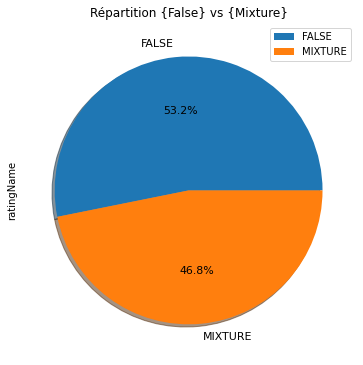

Statistique:
FALSE      4458
MIXTURE    3928
Name: ratingName, dtype: int64


In [ ]:
df_FM = df[df.truthRating != 3]
display_pie(df_FM, 'ratingName', 'Répartition {False} vs {Mixture}')

print("Statistique:")
print(df_FM["ratingName"].value_counts())

Pour rééquilibrer un jeu de donnée il existe de multiples méthodes mais nous allons en traiter deux ici:

- **Downslamping**
- **Upslamping**

En les utilisant nous pourront déterminer laquelle sera le plus optimal. Tout d'abord divisons nos différentes classes en trois dataframe distinct.

In [ ]:
nb_false, nb_mixture, nb_true = df["truthRating"].value_counts()

df_false = df[df['truthRating'] == 1]
df_mixture = df[df['truthRating'] == 2]
df_true = df[df['truthRating'] == 3]

### Précision avant sampling

# --- Application du classifieur 
[~] Fit réalisé en 0.401s
[~] Prédiction réalisée en 0.051s

[+] Accuracy: 73.628%

[~] Matrice de confusion:


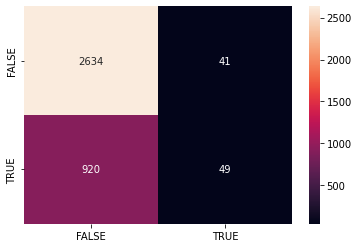


[~] Rapport de classification: 
               precision    recall  f1-score   support

       FALSE       0.74      0.98      0.85      2675
        TRUE       0.54      0.05      0.09       969

    accuracy                           0.74      3644
   macro avg       0.64      0.52      0.47      3644
weighted avg       0.69      0.74      0.65      3644



In [ ]:
data = df_TF['text']
target = df_TF['ratingName'].astype('string')

before_sampling = apply_classifier(pipeline, data, target, True)

### DownSlamping

La méthode de DownSlamping (ou sous-échantillonnage) processus de réduction de la fréquence d'échantillonnage. Ici c'est la réduction du nombre de données de la classe au nombre le plus élevée pour avoir le même nombre que la classe au nombre le plus faible.

Ici, avec **True vs False**, nous devrons donc réduire le nombre de classe **False**, pour se mettre à l'échelle du nombres de classe **True**. 


Répartition après DownSlamping:
FALSE    1614
TRUE     1614
Name: ratingName, dtype: int64 



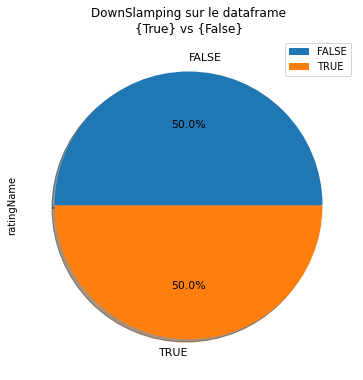

In [ ]:
df_false_down = df_false.sample(nb_true)
df_TF_DOWN = pandas.concat([df_false_down, df_true], axis=0)

print('Répartition après DownSlamping:')
print(df_TF_DOWN["ratingName"].value_counts(), '\n')
display_pie(df_TF_DOWN, 'ratingName', 'DownSlamping sur le dataframe\n{True} vs {False}')

Ici la classe False va perdre presque deux tiers.
Le jeu de donnée à était parfaitement équilibrée par rapport à notre classe **True**, testons notre classifieur sur ce nouveau jeu de donnée équilibrée.

# --- Application du classifieur 
[~] Fit réalisé en 0.068s
[~] Prédiction réalisée en 0.027s

[+] Accuracy: 59.577%

[~] Matrice de confusion:


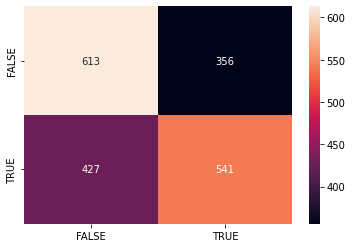


[~] Rapport de classification: 
               precision    recall  f1-score   support

       FALSE       0.59      0.63      0.61       969
        TRUE       0.60      0.56      0.58       968

    accuracy                           0.60      1937
   macro avg       0.60      0.60      0.60      1937
weighted avg       0.60      0.60      0.60      1937



0.5957666494579247

In [ ]:
data = df_TF_DOWN['text']
target = df_TF_DOWN['ratingName'].astype('string')

apply_classifier(pipeline, data, target, True)

Suite à la perte des données, la précision est bien plus faible qu'auparavant. Néanmoins la matrice de confusion est bien plus stable voir équivalente ce qui est plus acceptable.

### UpSlamping

La méthode de UpSlamping (ou sur-échantillonnage) est l'inverse du DownSlampling, son processus à pour but d'augmenter la fréquence d'échantillonnage.

Ce qui veut dire qu'avec **True vs Fals**e, nous devrons donc augmenter le nombre de classe **True**, pour s'ajuster au nombre de classe **False**. 

A l'inverse de la perte de données, c'est les données aléatoires qui sont créent pendant l'opération qui peuvent poser problème et fausser notre prédiction.

Répartition après Upslamping:
FALSE    4458
TRUE     4458
Name: ratingName, dtype: int64 



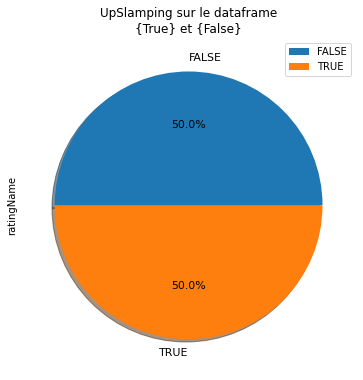

In [ ]:
df_true_up = df_true.sample(nb_false, replace=True)
df_TF_UP = pandas.concat([df_false, df_true_up], axis=0)

print('Répartition après Upslamping:')
print(df_TF_UP["ratingName"].value_counts(), '\n')
display_pie(df_TF_UP, 'ratingName', 'UpSlamping sur le dataframe\n{True} et {False}')

Le jeu de donnée à était parfaitement équilibrée par rapport à notre classe **False**, testons notre classifieur sur ce nouveau jeu de donnée équilibrée.

# --- Application du classifieur 
[~] Fit réalisé en 0.117s
[~] Prédiction réalisée en 0.064s

[+] Accuracy: 73.421%

[~] Matrice de confusion:


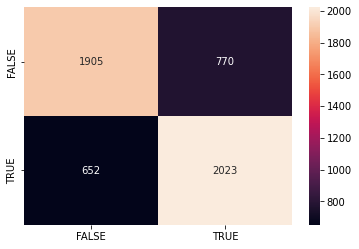


[~] Rapport de classification: 
               precision    recall  f1-score   support

       FALSE       0.75      0.71      0.73      2675
        TRUE       0.72      0.76      0.74      2675

    accuracy                           0.73      5350
   macro avg       0.73      0.73      0.73      5350
weighted avg       0.73      0.73      0.73      5350



In [ ]:
data = df_TF_UP['text']
target = df_TF_UP['ratingName'].astype('string')

after_upsampling = apply_classifier(pipeline, data, target, True)

Comme prévus, la précision est nettement plus élevé mais la matrice de confusion montre bien le désavatange de cette méthode. Le nombre de True positif est légèrement supérieur aux Faux positifs, alors qu'au départ c'était l'inverse. Malgré tout cette méthode reste très performante et offre un résultat très convenable, nous l'adopterons donc dans la poursuite de notre étude.

## Avant de poursuivre

Avant de poursuivre plus loin, nous allons Upsampler les différentes formes que nous devons étudier par la suite, à savoir (*True vs False vs Mixture*) et (*False vs Mixture*). Au final nous n'avons que (*True vs False vs Mixture*) à faire car False et Mixture possèdent le même nombres de données.

### Upsampling True vs False vs Mixture

Répartition après Upslamping:
FALSE      4458
TRUE       4458
MIXTURE    3928
Name: ratingName, dtype: int64 



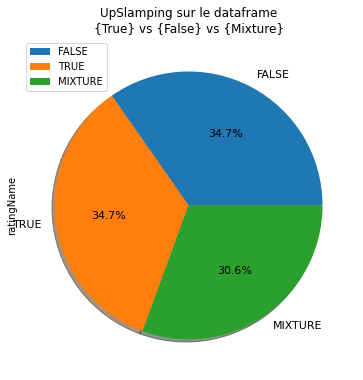

In [ ]:
df_true_up = df_true.sample(nb_false, replace=True)
df_TFM_UP = pandas.concat([df_false, df_mixture, df_true_up], axis=0)

print('Répartition après Upslamping:')
print(df_TFM_UP["ratingName"].value_counts(), '\n')
display_pie(df_TFM_UP, 'ratingName', 'UpSlamping sur le dataframe\n{True} vs {False} vs {Mixture}')

# 4 - Optimisation

Pour améliorer notre précision nous pouvons ajouter de nouvelles features lors de l'apprentissage, mais il faut les choisirs avec soin. En effet, de nouvelles données inutiles ajouterait du bruit à l'estimation, de même si l'on ajoute des informations redondante. Nous pouvons ainsi économiser du temps et/ou de l'argent en ne mesurant pas ces prédicteurs.

### Initialisation et mise en place

In [ ]:
def concat_features(df, features):


  data = df[features]
  return data.apply(
      lambda x: ' '.join(x.dropna().astype(str)),
      axis=1
  )

### Remove constant and select best features

Nous pouvons améliorer les features a faible variances en supprimant toutes les features inférieure à une certaines valeurs données. Après cette étape de nettoyage on peut utiliser un selecteur de feature qui choisis, ici, la moitié des features en fonction de leur poids.

In [ ]:
from sklearn.feature_selection import SelectFromModel, VarianceThreshold

TFIDF_VECT = TfidfVectorizer(min_df=0.001, ngram_range=(1,3))
VT = VarianceThreshold(threshold=0.0002)
SFM = SelectFromModel(LogisticRegression())

def get_pipeline_improved(classifier):
  
  return Pipeline([('tfidf', TFIDF_VECT),
                   ('feature_selection', SFM),
                   ('clf', classifier)])

# --- Application du classifieur 
[~] Fit réalisé en 1.711s
[~] Prédiction réalisée en 0.476s

[+] Accuracy: 77.589%

[~] Matrice de confusion:


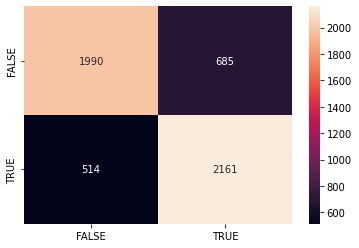


[~] Rapport de classification: 
               precision    recall  f1-score   support

       FALSE       0.79      0.74      0.77      2675
        TRUE       0.76      0.81      0.78      2675

    accuracy                           0.78      5350
   macro avg       0.78      0.78      0.78      5350
weighted avg       0.78      0.78      0.78      5350

[+] Feature selection accuracy: 77.59%


In [ ]:
from sklearn.ensemble import RandomForestClassifier


RF_pipeline = get_pipeline_improved(RandomForestClassifier())
feature_selection_accuracy = apply_classifier(RF_pipeline, data, target, True)

print("[+] Feature selection accuracy: %0.2f%%" 
      %to_percent(feature_selection_accuracy))

Le temps de calcul à était augmentée de 4s dû à ce nouveau classifieur mais nous gagnons $\approx4\%$ de précision ce qui n'est pas négligeable. 

## Ajouts de données additionnelles

Listons nos données additionnelles disponible:
* date
* author
* headline
* named_entities_claim
* named_entities_article
* keywords
* source
* sourceURL
* link
* language

La date n'est pas un élément utile, composé uniquement de chiffre elle n'apportera aucune information et ne sera que du bruit dans notre apprentissage. 

In [ ]:
unwanted = ['date']

Les liens relatifs et absolus, respectivement *sourceURL* et *link* sont aussi des sources de bruits qui sont généralement supprimé lors du prétraitement du texte, donc les ajouter n'est pas correcte. 

In [ ]:
unwanted.extend(['sourceURL', 'link'])

Le colonne *Language* est inutile dans le sens ou les données qui la composent est redondante. Composé entièrement de la même valeur, ici "English". Les données comme celles-ci sont inutiles pour améliorer les prédictions.

In [ ]:
unwanted.append('language')

In [ ]:
_df = df_TF_UP.drop(unwanted, axis=1)
_df.head()

,text,author,headline,named_entities_claim,named_entities_article,keywords,source,truthRating,ratingName
2,ted cruz said veteran start sell cooki order r...,unknown,ted cruz vet sell cooki fund like girl scout,david nelson james morrison john scalzi republ...,ted cruz,asp article necessarily news,snopes,1,FALSE
5,georgia lotteri corp onli onc past year paid a...,allie mccullen,luck run student lotteri claim,georgia lottery hope scholarship mega millions...,georgia lottery hope scholarship,education,politifact,1,FALSE
7,panda express celebr th anniversari offer disc...,unknown,panda express th anniversari offer,los angeles times panda express panda inn wend...,panda express,asp article something nothing,snopes,1,FALSE
9,alon infant report die follow attempt abort no...,americans united life,american unit life say babi die attempt abort,alan guttmacher institute americans united lif...,,abortion,politifact,1,FALSE
15,video show dutch politician tunahan kuzu put g...,unknown,dutch politician put grill chees sandwich pock...,tunahan kuzu twitter grilled cheese sandwich i...,tunahan kuzu,grilled cheese tunahan kuzu,snopes,1,FALSE



Comparons le bénéfices de précision obtenus lors de l'ajout d'une unique feature, avec notre texte principal, nous pourrons ainsi déterminer des conclusions sur notre méthodes de choix.

In [ ]:
features = list(_df.columns)[:-2]
accuracies = []

for feature in features[1:]:
  actual_features = ['text', feature]
  data = concat_features(_df, actual_features)
  accuracy = apply_classifier(RF_pipeline, data, target)
  print("Features:", actual_features, 
        "| Accuracy: %0.2f%%" % to_percent(accuracy))
  accuracies.append(accuracy)

Features: ['text', 'author'] | Accuracy: 79.48%
Features: ['text', 'headline'] | Accuracy: 79.94%
Features: ['text', 'named_entities_claim'] | Accuracy: 80.47%
Features: ['text', 'named_entities_article'] | Accuracy: 77.61%
Features: ['text', 'keywords'] | Accuracy: 79.31%
Features: ['text', 'source'] | Accuracy: 79.14%


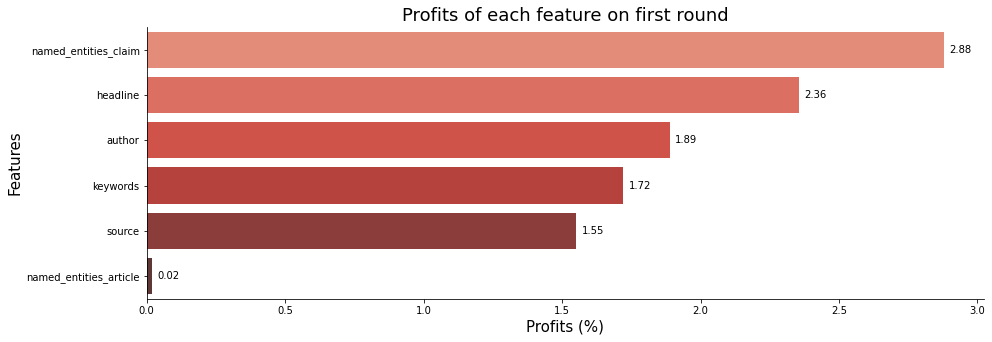

In [ ]:
profits = [to_percent(accuracy - feature_selection_accuracy) for accuracy in accuracies]

# mise à l'échelle si nécessaire
# min = np.min(profits)
# if (min < 0): profits = list(map(lambda x: x + abs(min), profits))

df_profits = pandas.DataFrame({
    'features': features[1:], 
    'profits': profits})
df_profits = df_profits.sort_values(by='profits', ascending=False)

display_barplot(df_profits, 
                "Profits of each feature on first round", 
                'profits', 
                'Profits (%)',
                'features', 
                'Features', 
                'h')




Toutes les données sembles utiles à ajouter. Sauf named_entities_article qui est très faible et author car on le rappelle celui-ci appartient déjà à named_entities_claim

In [ ]:
features = ['text', 'named_entities_claim', 'headline', 'keywords', 'source']

### Précision avec les nouvelles données

[+] Features: ['text', 'named_entities_claim', 'headline', 'keywords', 'source'] 

# --- Application du classifieur 
[~] Fit réalisé en 2.913s
[~] Prédiction réalisée en 0.923s

[+] Accuracy: 82.542%

[~] Matrice de confusion:


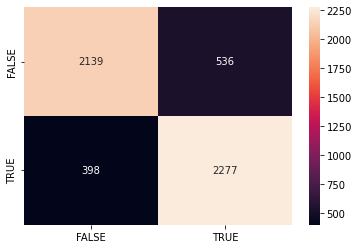


[~] Rapport de classification: 
               precision    recall  f1-score   support

       FALSE       0.84      0.80      0.82      2675
        TRUE       0.81      0.85      0.83      2675

    accuracy                           0.83      5350
   macro avg       0.83      0.83      0.83      5350
weighted avg       0.83      0.83      0.83      5350



In [ ]:
print("[+] Features:", features, "\n")

data = concat_features(_df, features)
TF_accuracy = apply_classifier(RF_pipeline, data, target, True)

Avec toutes les données nous obtenons un score avoisinant les $80.4\%$ soit $\approx5\%$ de plus que notre score précédent.

### Initialisation des fonctions et des classifieurs

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

SEED = 42
models = ['RandomForest', 'KNeighbors', 'SGD', 'LogisticRegression']

classifiers = {
    models[0]: RandomForestClassifier(random_state=SEED, n_jobs=-1), 
    models[1]: KNeighborsClassifier(n_jobs=-1), 
    models[2]: SGDClassifier(random_state=SEED, n_jobs=-1),
    models[3]: LogisticRegression(random_state=SEED, n_jobs=-1)
}

params = {
  models[0]: {
      'clf__min_samples_split': [1, 2, 3],
      'clf__min_samples_leaf': [1, 2, 3],
      'clf__n_estimators': [100, 200, 300],
      'clf__criterion': ['gini', 'entropy']
  },
  models[1]: {
      'clf__n_neighbors': [5, 10], 
      'clf__weights': ['uniform', 'distance'], 
      'clf__leaf_size': [2, 5]
  },
  models[2]: {
      'clf__max_iter': [500, 1000, 2000],
      'clf__penalty': ['l1', 'l2', 'elasticnet']
  },
  models[3]: {
      'clf__max_iter': [1000, 2500, 5000],
      'clf__C': [1, 2], 
      'clf__solver' : ['lbfgs', 'liblinear']
  }
}

Nos classifieurs et leur différents paramètres sont en place, il ne nous reste plus qu'à ajouter une fonction permettant d'itérer sur nos différents modèles pour les tester un a un et renvoyer le meilleur d'entre eux.

In [ ]:
from sklearn.model_selection import GridSearchCV 

def init_grid_search(pipeline, params):

  return GridSearchCV(pipeline, params, scoring='accuracy', n_jobs=-1)

def apply_grid(grid, X_train, X_test, y_train, y_test, 
               disp=False, classifier_name=''):


  # --- Mise en place du GridSearch
  if disp: print("# --- Application du classifieur", classifier_name)

  # --- Fit
  t0 = time()
  grid.fit(X_train, y_train)
  if disp: print("[~] Fit réalisé en %0.3fs" % (time() - t0))

  # --- Predict
  t0 = time()
  result = grid.predict(X_test)
  if disp: print("[~] Prédiction réalisée en %0.3fs\n" % (time() - t0))

  # --- Accuracy
  accuracy = accuracy_score(y_test, result)
  best_params = grid.best_params_
  print('[+] Accuracy: %0.3f%%' % to_percent(accuracy))
  print("[+] Meilleurs paramètres: ", best_params)
  
  # --- Confusion Matrix
  conf = confusion_matrix(y_test, result)
  if disp: 
    print('\n[~] Matrice de confusion:')
    labels = np.unique(y_test)
    display_confusion_matrix(conf, labels)

  # --- Report
  if disp: 
    print('\n[~] Rapport de classification: \n', classification_report(y_test, 
                                                                       result))
  return [accuracy, best_params]


def get_best_classifier(models, classifiers, params, data, target, disp):

  # --- Mise en place du jeu de test
  validation_size = 0.4
  testsize= 1 - validation_size
  X_train, X_test, y_train, y_test = train_test_split(
      data, 
      target, 
      train_size=validation_size, 
      test_size=testsize,
      random_state=SEED,
      stratify=target
  )

  best_model = ''
  best_accuracy = 0.0
  best_params = {}

  for model in models:
    pipeline = get_pipeline_improved(classifiers[model])
    grid = init_grid_search(pipeline, params[model])
    result = apply_grid(grid, X_train, X_test, y_train, y_test, disp, model)

    if (result[0] > best_accuracy):
      best_model = model
      best_accuracy = result[0]
      best_params = result[1]

  return [best_model, best_accuracy, best_params]

### Meilleur classifier : ( Prend environ 12min pour s'éxécuter )



# --- Application du classifieur RandomForest


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packa

[~] Fit réalisé en 567.485s
[~] Prédiction réalisée en 1.201s

[+] Accuracy: 82.841%
[+] Meilleurs paramètres:  {'clf__criterion': 'entropy', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3, 'clf__n_estimators': 300}

[~] Matrice de confusion:


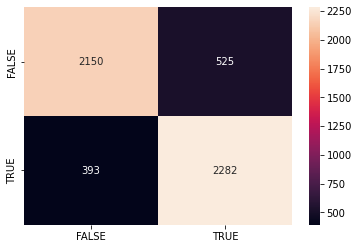


[~] Rapport de classification: 
               precision    recall  f1-score   support

       FALSE       0.85      0.80      0.82      2675
        TRUE       0.81      0.85      0.83      2675

    accuracy                           0.83      5350
   macro avg       0.83      0.83      0.83      5350
weighted avg       0.83      0.83      0.83      5350

# --- Application du classifieur KNeighbors
[~] Fit réalisé en 32.328s
[~] Prédiction réalisée en 1.732s

[+] Accuracy: 68.131%
[+] Meilleurs paramètres:  {'clf__leaf_size': 2, 'clf__n_neighbors': 5, 'clf__weights': 'distance'}

[~] Matrice de confusion:


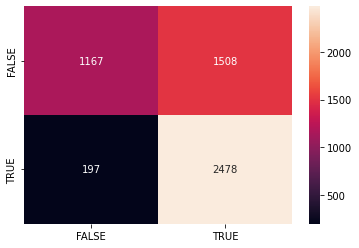


[~] Rapport de classification: 
               precision    recall  f1-score   support

       FALSE       0.86      0.44      0.58      2675
        TRUE       0.62      0.93      0.74      2675

    accuracy                           0.68      5350
   macro avg       0.74      0.68      0.66      5350
weighted avg       0.74      0.68      0.66      5350

# --- Application du classifieur SGD
[~] Fit réalisé en 33.161s
[~] Prédiction réalisée en 0.707s

[+] Accuracy: 77.776%
[+] Meilleurs paramètres:  {'clf__max_iter': 500, 'clf__penalty': 'elasticnet'}

[~] Matrice de confusion:


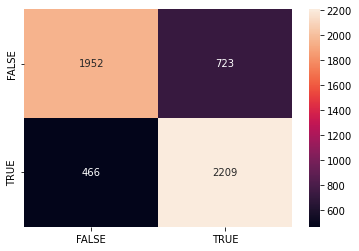


[~] Rapport de classification: 
               precision    recall  f1-score   support

       FALSE       0.81      0.73      0.77      2675
        TRUE       0.75      0.83      0.79      2675

    accuracy                           0.78      5350
   macro avg       0.78      0.78      0.78      5350
weighted avg       0.78      0.78      0.78      5350

# --- Application du classifieur LogisticRegression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[~] Fit réalisé en 44.239s
[~] Prédiction réalisée en 0.731s

[+] Accuracy: 76.187%
[+] Meilleurs paramètres:  {'clf__C': 2, 'clf__max_iter': 1000, 'clf__solver': 'liblinear'}

[~] Matrice de confusion:


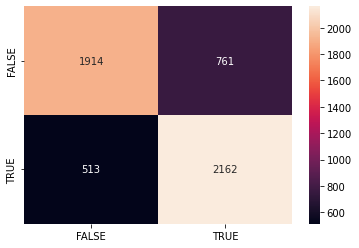


[~] Rapport de classification: 
               precision    recall  f1-score   support

       FALSE       0.79      0.72      0.75      2675
        TRUE       0.74      0.81      0.77      2675

    accuracy                           0.76      5350
   macro avg       0.76      0.76      0.76      5350
weighted avg       0.76      0.76      0.76      5350


--------------------------------------------------------------------- 
[+] Meilleur classifieur: RandomForest 
[+] Accuracy: 82.841% 
[+] Params:  {'clf__criterion': 'entropy', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3, 'clf__n_estimators': 300}


In [ ]:
data = concat_features(_df, features)
target = _df['ratingName'].astype('string')

result = get_best_classifier(models, classifiers, params, data, target, True)

print("\n---------------------------------------------------------------------",
      "\n[+] Meilleur classifieur:", result[0], 
      "\n[+] Accuracy: %0.3f%%" % to_percent(result[1]),
      "\n[+] Params: ", result[2])

Le classifier RandomForest (RF) qui arrive en tête avec un taux de précision avoisinnant les $\approx80.2\%$, talonné par LogisticRegression (LR) avec près de $\approx78.9\%$. Nous avons donc encore réussi à améliorer notre modèles.

### Sauvegarde

Sauvegardons nos deux meilleurs résultat pour éviter de réexécuter notre benchmark à chaque fois. Nous conservons les deux premiers au cas ou par la suite nous souhaiterions encore une fois les comparer.

In [ ]:
# --- Save the best accuracy found
best_clf_accuracy = result[1]

In [ ]:
# --- Best classifier
best_clf_name = "RandomForest"
best_clf = classifiers[best_clf_name]

params = {'criterion': 'entropy', 
          'min_samples_leaf': 1, 'min_samples_split': 3, 
          'n_estimators': 300}
best_clf.set_params(**params)

best_clf_pipeline = get_pipeline_improved(best_clf)
print("[+] Best classifier: \n", best_clf)

# --- Second best classifier
LR_name = "LogisticRegression"
LR_clf = classifiers[LR_name]

params = {'C': 2, 'max_iter': 1000, 'solver': 'lbfgs'}
LR_clf.set_params(**params)

LR_pipeline = get_pipeline_improved(LR_clf)
print("[+] Second best classifier: \n", LR_clf)

[+] Best classifier: 
 RandomForestClassifier(criterion='entropy', min_samples_split=3,
                       n_estimators=300, n_jobs=-1, random_state=42)
[+] Second best classifier: 
 LogisticRegression(C=2, max_iter=1000, n_jobs=-1, random_state=42)


### Conclusion

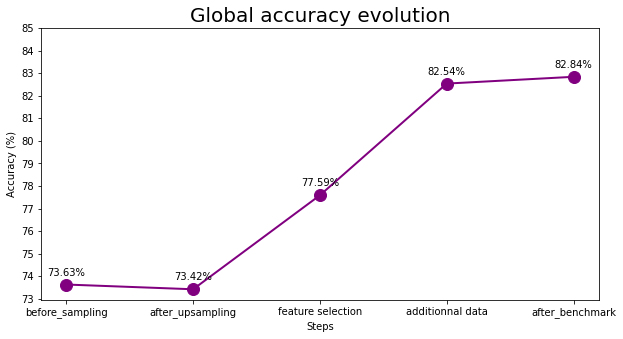

In [ ]:
x = ["before_sampling", "after_upsampling", 
     "feature selection", 
     "additionnal data",
     "after_benchmark"]

y = [to_percent(before_sampling), to_percent(after_upsampling),
     to_percent(feature_selection_accuracy),
     to_percent(TF_accuracy),
     to_percent(best_clf_accuracy)]
y = list(map(lambda x: round(x, 2), y))

# --- Plot
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(x, y,
         marker='o', markersize=12,
         linewidth=2, color='purple')

# --- Cosmetic
plt.title(label='Global accuracy evolution', fontsize=20)
plt.xlabel('Steps')
plt.ylabel('Accuracy (%)')

# --- Labels on marker
for a,b in zip(x, y): 
  plt.text(a, b+0.4, str(b)+"%", ha="center")

# --- Ticks
yticks_min = round(np.amin(y))
yticks_max = round(np.amax(y))+3
plt.yticks(np.arange(yticks_min, yticks_max, 1))

plt.show()

In [ ]:
print("Bénéfices global: +%0.2f%%" %to_percent(best_clf_accuracy - before_sampling))

Bénéfices global: +9.21%


## Faux vs Mixture

In [ ]:
_df = df_FM.drop(unwanted, axis=1)
_df.head()

,text,author,headline,named_entities_claim,named_entities_article,keywords,source,truthRating,ratingName
0,revenu generat drill virginia coast million year,jim moran,moran say drill virginia coast net onli millio...,alaska american petroleum institute atlantic o...,,energy state finances,politifact,2,MIXTURE
1,health insur compani pay ceo million year,health care america,health care advocaci group blast insur ceo pay...,aetna assurant bloomberg news cigna coventry h...,,corporations health care,politifact,2,MIXTURE
2,ted cruz said veteran start sell cooki order r...,unknown,ted cruz vet sell cooki fund like girl scout,david nelson james morrison john scalzi republ...,ted cruz,asp article necessarily news,snopes,1,FALSE
3,passeng airlin divert cuba thought hijack cand...,unknown,airlin passeng mistak hijack candid camera stunt,allen funt associated press cbs candid camera ...,allen funt candid camera cuba,broadcast legends radio tv television,snopes,2,MIXTURE
4,oil money feder leas onli use clean mess damag...,bill nelson,sen bill nelson say offshor drill wo nt pay fl...,alabama bill nelson dfla florida panhandle gul...,,environment,politifact,2,MIXTURE


In [ ]:
def display_unique_data_profits(df, classifier, features, target):
  
  witness_acc = apply_classifier(classifier, df['text'], target)
  print("Witness accuracy: %0.2f%%" % to_percent(witness_acc))

  accuracies = []

  # --- get profits
  for feature in features:
    actual_features = ['text', feature]
    data = concat_features(_df, actual_features)
    accuracy = apply_classifier(classifier, data, target)
    print("Features:", actual_features, 
          "| Accuracy: %0.2f%%" % to_percent(accuracy))
    accuracies.append(accuracy)
    
  profits = [to_percent(accuracy - witness_acc) for accuracy in accuracies]
  
  # --- store and order in a dataframe
  df_profits = pandas.DataFrame({
    'features': features, 
    'profits': profits})
  df_profits = df_profits.sort_values(by='profits', ascending=False)

  # --- display them
  display_barplot(df_profits, 
                  "Profits of each feature on first round", 
                  'profits', 
                  'Profits (%)',
                  'features', 
                  'Features', 
                  'h')

Witness accuracy: 66.24%
Features: ['text', 'author'] | Accuracy: 70.97%
Features: ['text', 'headline'] | Accuracy: 69.46%
Features: ['text', 'named_entities_claim'] | Accuracy: 73.71%
Features: ['text', 'named_entities_article'] | Accuracy: 65.66%
Features: ['text', 'keywords'] | Accuracy: 69.55%
Features: ['text', 'source'] | Accuracy: 69.26%


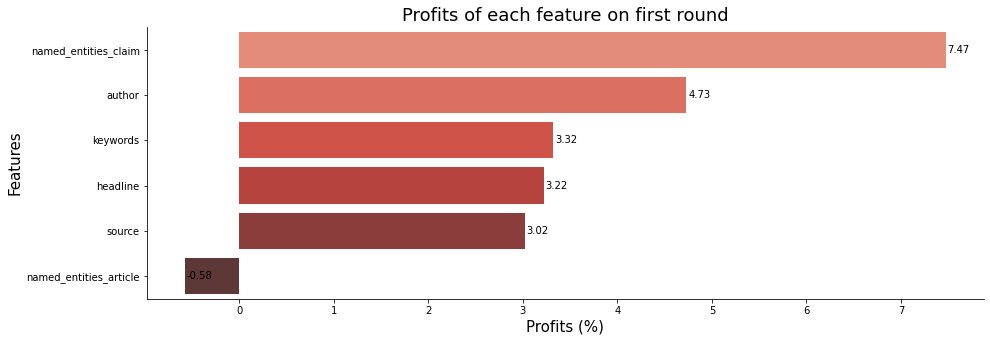

In [ ]:
additionnal_features = list(_df.columns)[1:-2]
target = _df['ratingName'].astype('string')
display_unique_data_profits(_df, best_clf_pipeline, additionnal_features, target)

Witness accuracy: 67.59%
Features: ['text', 'author'] | Accuracy: 71.50%
Features: ['text', 'headline'] | Accuracy: 69.52%
Features: ['text', 'named_entities_claim'] | Accuracy: 72.85%
Features: ['text', 'named_entities_article'] | Accuracy: 67.73%
Features: ['text', 'keywords'] | Accuracy: 70.77%
Features: ['text', 'source'] | Accuracy: 70.33%


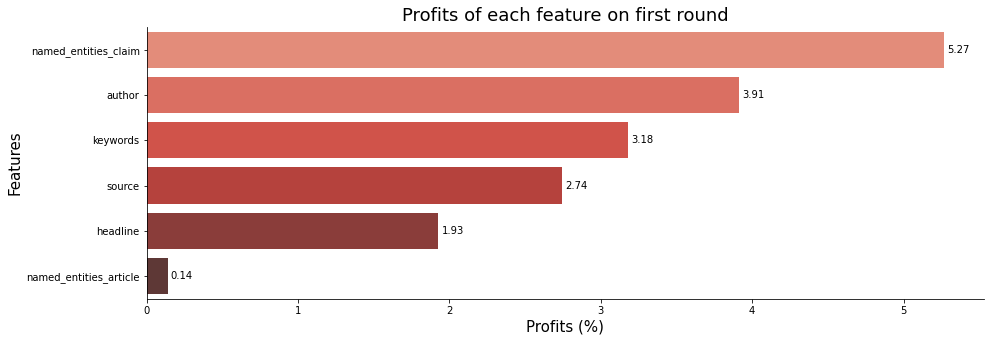

In [ ]:
display_unique_data_profits(_df, LR_pipeline, additionnal_features, target)

Même constat que pour True vs False

In [ ]:
features = ['text', 'named_entities_claim', 'headline', 'keywords', 'source']

# --- Application du classifieur 
[~] Fit réalisé en 5.771s
[~] Prédiction réalisée en 1.072s

[+] Accuracy: 74.444%

[~] Matrice de confusion:


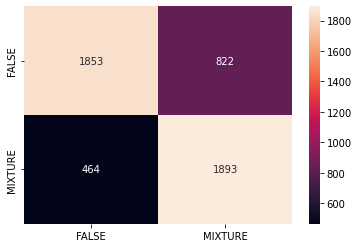


[~] Rapport de classification: 
               precision    recall  f1-score   support

       FALSE       0.80      0.69      0.74      2675
     MIXTURE       0.70      0.80      0.75      2357

    accuracy                           0.74      5032
   macro avg       0.75      0.75      0.74      5032
weighted avg       0.75      0.74      0.74      5032



In [ ]:
data = concat_features(_df, features)
FM_accuracy = apply_classifier(best_clf_pipeline, data, target, True)

## True vs False vs Mixture

In [ ]:
_df = df_TFM_UP.drop(unwanted, axis=1)
_df.head()

,text,author,headline,named_entities_claim,named_entities_article,keywords,source,truthRating,ratingName
2,ted cruz said veteran start sell cooki order r...,unknown,ted cruz vet sell cooki fund like girl scout,david nelson james morrison john scalzi republ...,ted cruz,asp article necessarily news,snopes,1,FALSE
5,georgia lotteri corp onli onc past year paid a...,allie mccullen,luck run student lotteri claim,georgia lottery hope scholarship mega millions...,georgia lottery hope scholarship,education,politifact,1,FALSE
7,panda express celebr th anniversari offer disc...,unknown,panda express th anniversari offer,los angeles times panda express panda inn wend...,panda express,asp article something nothing,snopes,1,FALSE
9,alon infant report die follow attempt abort no...,americans united life,american unit life say babi die attempt abort,alan guttmacher institute americans united lif...,,abortion,politifact,1,FALSE
15,video show dutch politician tunahan kuzu put g...,unknown,dutch politician put grill chees sandwich pock...,tunahan kuzu twitter grilled cheese sandwich i...,tunahan kuzu,grilled cheese tunahan kuzu,snopes,1,FALSE


In [ ]:
def get_pipeline_improved_bis(classifier):
  
  _SFM = SelectFromModel(best_clf)
  return Pipeline([('tfidf', TFIDF_VECT),
                   ('feature_selection', _SFM),
                   ('clf', classifier)])

Witness accuracy: 62.72%
Features: ['text', 'author'] | Accuracy: 67.32%
Features: ['text', 'headline'] | Accuracy: 66.84%
Features: ['text', 'named_entities_claim'] | Accuracy: 69.13%
Features: ['text', 'named_entities_article'] | Accuracy: 62.89%
Features: ['text', 'keywords'] | Accuracy: 66.00%
Features: ['text', 'source'] | Accuracy: 65.98%


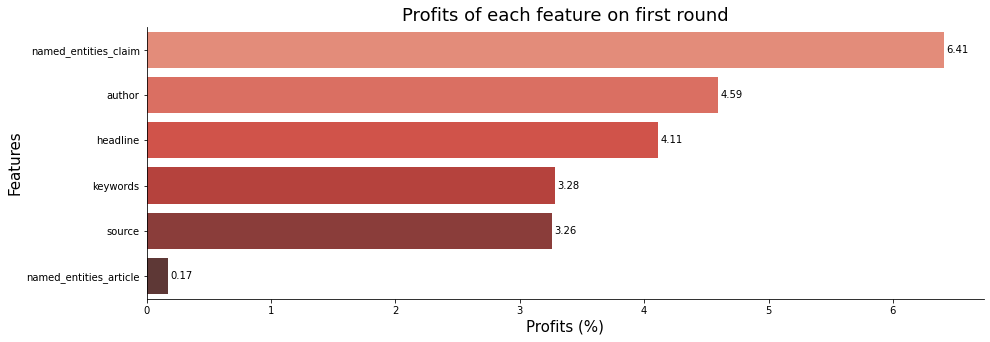

In [ ]:
_pipeline = get_pipeline_improved_bis(best_clf)
target = _df['ratingName'].astype('string')
display_unique_data_profits(_df, _pipeline, additionnal_features, target)

# --- Application du classifieur 
[~] Fit réalisé en 26.030s
[~] Prédiction réalisée en 1.954s

[+] Accuracy: 70.780%

[~] Matrice de confusion:


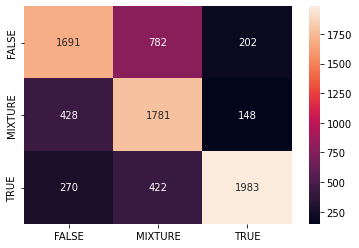


[~] Rapport de classification: 
               precision    recall  f1-score   support

       FALSE       0.71      0.63      0.67      2675
     MIXTURE       0.60      0.76      0.67      2357
        TRUE       0.85      0.74      0.79      2675

    accuracy                           0.71      7707
   macro avg       0.72      0.71      0.71      7707
weighted avg       0.72      0.71      0.71      7707



In [ ]:
features = ['text', 'named_entities_claim', 'headline', 'keywords', 'source']
data = concat_features(_df, features)
TFM_accuracy = apply_classifier(_pipeline, data, target, True)